# Redes Neurais Artificiais 2025.2

- **Disciplina**: Redes Neurais Artificiais 2025.2
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta parte do Projeto Prático diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Busca em Grade

Uma maneira padrão de escolher os parâmetros de um modelo de Machine Learning é por meio de uma busca em grade via força bruta. O algoritmo da busca em grade é dado como segue:

1. Escolha a métrica de desempenho que você deseja maximizar  
2. Escolha o algoritmo de Machine Learning (exemplo: redes neurais artificiais). Em seguida, defina os parâmetros ou hiperparâmetros deste tipo de modelo sobre os quais você dseja otimizar (número de épocas, taxa de aprendizado, etc.) e construa um array de valores a serem testados para cada parâmetro ou hiperparâmetro.  
3. Defina a grade de busca, a qual é dada como o produto cartesiano de cada parâmetro a ser testado. Por exemplo, para os arrays [50, 100, 1000] e [10, 15], tem-se que a grade é [(50,10), (50,15), (100,10), (100,15), (1000,10), (1000,15)].
4. Para cada combinação de parâmetros a serem otimizados, utilize o conjunto de treinamento para realizar uma validação cruzada (holdout ou k-fold) e calcule a métrica de avaliação no conjunto de teste (ou conjuntos de teste)
5. Escolha a combinação de parâmetros que maximizam a métrica de avaliação. Este é o modelo otimizado.

Por que esta abordagem funciona? Porque a busca em grade efetua uma pesquisa extensiva sobre as possíveis combinações de valores para cada um dos parâmetros a serem ajustados. Para cada combinação, ela estima a performance do modelo em dados novos. Por fim, o modelo com melhor métrica de desempenho é escolhido. Tem-se então que este modelo é o que melhor pode vir a generalizar mediante dados nunca antes vistos.

## Efetuando a Busca em Grade sobre Hiperparâmetros das Top-6 RNAs

Considerando a etapa anterior do projeto prático, foram identificadas pelo menos 6 melhores Redes Neurais para o problema da classificação multi-classe da cobertura florestal no conjunto de dados selecionado. Algumas destas redes possuem atributos categóricos como variáveis preditoras, enquanto outras possuem apenas os atributos numéricos como preditores.

A primeira etapa desta segunda parte do projeto consiste em trazer para este notebook estas seis arquiteturas, ressaltando:

1. Número de neurônios ocultos por camada  
2. Função de Ativação  
3. Utilização ou não de atributos categóricos   
4. Desempenho médio +- desvio padrão nos testes anteriores  
5. Número de repetições que a equipe conseguiu realizar para verificar os resultados  

Elabore uma busca em grade sobre estas arquiteturas que contemple variações nos hiperparâmetros a seguir, conforme documentação de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

A. Solver  (Não usar o LBFGS, pois é mais adequado para datasets pequenos)  
B. Batch Size  
C. Learning Rate Init  
D. Paciência (n_iter_no_change)  
E. Épocas  

Nesta busca em grande, contemple a utilização do objeto [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [23]:
import kagglehub
import pandas as pd
import numpy as np
import pickle as pkl
from prettytable import PrettyTable
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# Top 6 arquiteturas
Top_6_architectures = [
    {'layers' : (60, 40, 30), 'activation' : 'relu',      'categorical': False, 'stdev' : 0, 'iterations': 100},
    {'layers' : (50, 30, 20), 'activation' : 'tanh',      'categorical': False, 'stdev' : 0, 'iterations': 100},
    {'layers' : (100),        'activation' : 'tanh',      'categorical': False, 'stdev' : 0, 'iterations': 100},
    {'layers' : (25, 12),     'activation' : 'logistic',  'categorical': False, 'stdev' : 0, 'iterations': 100},
    {'layers' : (25, 12),     'activation' : 'relu',      'categorical': False, 'stdev' : 0, 'iterations': 100},
    {'layers' : (16, 8),      'activation' : 'logistic',  'categorical': False, 'stdev' : 0, 'iterations': 100},
]

In [3]:
table = PrettyTable()
table.field_names = ["Arquitetura", "Ativação", "Atributos Categoricos", "Desvio Padrão", "Repetições"]
for p in Top_6_architectures:
    table.add_row([f'{p['layers']}', f'{p['activation']}', f'{p['categorical']}', f'{p['stdev']}', f'{p['iterations']}'])
display(table)

Arquitetura,Ativação,Atributos Categoricos,Desvio Padrão,Repetições
"(60, 40, 30)",relu,False,0,100
"(50, 30, 20)",tanh,False,0,100
100,tanh,False,0,100
"(25, 12)",logistic,False,0,100
"(25, 12)",relu,False,0,100
"(16, 8)",logistic,False,0,100


## Validação Cruzada k-fold

Na elaboração da busca em grid, vamos avaliar os modelos propostos segundo uma estratégia de validação cruzada ainda não explorada até o momento: a validação cruzada k-fold. Segundo a mesma, o conjunto de dados é particionado em k partes: a cada iteração, separa-se uma das partes para teste e o modelo é treinado com as k-1 partes remanescentes. Valores sugestivos de k na literatura são k = 3, 5 ou 10, pois o custo computacional desta validação dos modelos é alto. A métrica de desempenho é resultante da média dos desempenhos nas k iterações. A figura a seguir ilustra a ideia desta avaliação

<img src = "https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600></img>

Considerando a métrica de desempenho F1-Score, considere a validação cruzada 5-fold para aferir os resultados da busca em grande anterior.

In [4]:
# Download latest version
path = kagglehub.dataset_download("uciml/forest-cover-type-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Felix\.cache\kagglehub\datasets\uciml\forest-cover-type-dataset\versions\1


In [5]:
# Carregando a base de dados
df = pd.read_csv(path + "/covtype.csv")
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [6]:
# Separando preditores (X) e variável-alvo (y)
X = df.drop(columns=["Cover_Type"]);
y = df["Cover_Type"];

In [7]:
# Separando colunas numéricas e categóricas
categorical_columns = X.columns[X.columns.str.contains("Soil_Type") | X.columns.str.contains("Wilderness_Area")]
numeric_columns = X.columns.drop(categorical_columns)

print(numeric_columns)
print(categorical_columns)

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points'],
      dtype='object')
Index(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soi

In [8]:
# Escalonando variáveis numéricas com StandardScaler e ignorando as categoricas
transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', 'passthrough', categorical_columns)
    ]
)

# Escalona as Variáveis
X_full_transformed = transformer.fit_transform(X)
# Recupera os nomes das colunas após o ColumnTransformer
feature_names = list(numeric_columns) + list(categorical_columns)
# Converte de volta para DataFrame
X_full_scaled = pd.DataFrame(X_full_transformed, columns=feature_names)
print(f'Primeira instância da variváveis (X) escalonadas:\n{X_full_transformed[0]}')

Primeira instância da variváveis (X) escalonadas:
[-1.29780509 -0.93515698 -1.48281978 -0.0537674  -0.79627259 -1.18014587
  0.33074321  0.43914331  0.1429604   3.24628306  1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


In [ ]:
# Arquitetura Top 6
architectures_final = [
    {'layers' : (60, 40, 30), 'activation' : 'relu',      'categorical': False},
    {'layers' : (50, 30, 20), 'activation' : 'tanh',      'categorical': False},
    {'layers' : (100),        'activation' : 'tanh',      'categorical': False},
    {'layers' : (25, 12),     'activation' : 'logistic',  'categorical': False},
    {'layers' : (25, 12),     'activation' : 'relu',      'categorical': False},
    {'layers' : (16, 8),      'activation' : 'logistic',  'categorical': False},
]

# Paramatros de busca em grade
params = {
    'solver': ['sgd', 'adam'],
    'batch_size': [32, 64],
    'learning_rate_init': [0.001], 0.0001],
    'n_iter_no_change': [5, 10],
    'max_iter': [50, 100], # utilizando baixo número de iterações por causa do alto custo computacional.
}

In [11]:
resultados_grid_search = []
cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42) # Validação Cruzada em 5 folds
scoring_metric = 'f1_weighted' # Métrica de desempenho f1_score

for i, arch in enumerate(architectures_final):
    print(f"\n-> Processando Treino {i+1}/{len(architectures_final)}: Arquitetura: Layers={arch['layers']}, Activation={arch['activation']}, Categóricos={arch['categorical']}")
    print("-" * 80)

    if arch['categorical']:
      X_train = X_full_scaled
    else:
      X_train = X_full_scaled[numeric_columns]
    
    mlp = MLPClassifier(
      hidden_layer_sizes=arch['layers'],
      activation=arch['activation']
      )

    search = GridSearchCV(
        estimator=mlp,
        param_grid=params,
        scoring=scoring_metric,
        cv=cv_kfold,
        n_jobs=6,
        verbose=3
    )

    search.fit(X_train, y)

    best_params = search.best_params_
    best_score = search.best_score_

    resultados_grid_search.append(
        {
            'architecture': arch,
            'best_params': best_params,
            'best_score': best_score,
            'search_object' : search
        }
    )


-> Processando Treino 1/6: Arquitetura: Layers=(60, 40, 30), Activation=relu, Categóricos=False
--------------------------------------------------------------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(



-> Processando Treino 2/6: Arquitetura: Layers=(50, 30, 20), Activation=tanh, Categóricos=False
--------------------------------------------------------------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(



-> Processando Treino 3/6: Arquitetura: Layers=100, Activation=tanh, Categóricos=False
--------------------------------------------------------------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(



-> Processando Treino 4/6: Arquitetura: Layers=(25, 12), Activation=logistic, Categóricos=False
--------------------------------------------------------------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(



-> Processando Treino 5/6: Arquitetura: Layers=(25, 12), Activation=relu, Categóricos=False
--------------------------------------------------------------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(



-> Processando Treino 6/6: Arquitetura: Layers=(16, 8), Activation=logistic, Categóricos=False
--------------------------------------------------------------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


## Identificando a mellhor solução

Como resultado da busca em grande com validação cruzada 5-fold, identifique o modelo otimizado com melhor desempenho para o problema. Apresente claramente este modelo, seus parâmetros, hiperparâmetros otimizados e resultados para cada um dos folds avaliados. Esta é a melhor solução identificada em decorrência deste projeto

In [12]:
melhor_resultado = max(resultados_grid_search, key=lambda x: x['best_score'])

melhor_arquitetura = melhor_resultado['architecture']
melhor_score_medio = melhor_resultado['best_score']
melhores_hiperparametros = melhor_resultado['best_params']
search_vencedor = melhor_resultado['search_object']

indice_melhor_combinacao = search_vencedor.best_index_

cv_results = search_vencedor.cv_results_
pontuacoes_folds = [cv_results[f'split{i}_test_score'][indice_melhor_combinacao] for i in range(5)]

In [30]:
# 1. Tabela de Detalhes do Modelo
details_table = PrettyTable()
details_table.title = "Modelo Otimizado com Melhor Desempenho Global"
details_table.field_names = ["Detalhe", "Valor"]
details_table.align["Detalhe"] = "l"
details_table.align["Valor"] = "l"

# Informações da Arquitetura Base
details_table.add_row(["Arquitetura Base (Camadas)", str(melhor_arquitetura['layers'])])
details_table.add_row(["Função de Ativação", melhor_arquitetura['activation']])
details_table.add_row(["Uso de Categóricos", "Sim" if melhor_arquitetura['categorical'] else "Não"])
details_table.add_row(["---", "---"])

# Hiperparâmetros Otimizados
details_table.add_row(["HIPERPARÂMETROS OTIMIZADOS", ""])
for param, value in melhores_hiperparametros.items():
    details_table.add_row([f"   - {param.replace('_', ' ').title()}", str(value)])
    
details_table.add_row(["---", "---"])

# Desempenho
details_table.add_row(["MÉTRICA DE DESEMPENHO", "F1-Weighted"])
details_table.add_row(["F1-SCORE MÉDIO (5-Fold)", f"{melhor_score_medio:.4f}"])

print(details_table)

# 2. Tabela de Desempenho por Fold
folds_table = PrettyTable()
folds_table.title = "Desempenho Detalhado por Fold (K=5)"
folds_table.field_names = ["Fold de Validação", "F1-Score (Teste)"]
folds_table.float_format = ".4"
folds_table.align["Fold de Validação"] = "l"

for i, score in enumerate(pontuacoes_folds):
    folds_table.add_row([f"Fold {i+1}", score])
    
# Adiciona a linha da Média
folds_table.add_row(["---", "---"])
folds_table.add_row(["Média (Final)", melhor_score_medio])

print(folds_table)

+-----------------------------------------------+
| Modelo Otimizado com Melhor Desempenho Global |
+------------------------------+----------------+
| Detalhe                      | Valor          |
+------------------------------+----------------+
| Arquitetura Base (Camadas)   | (50, 30, 20)   |
| Função de Ativação           | tanh           |
| Uso de Categóricos           | Não            |
| ---                          | ---            |
| HIPERPARÂMETROS OTIMIZADOS   |                |
|    - Batch Size              | 32             |
|    - Learning Rate Init      | 0.001          |
|    - Max Iter                | 25             |
|    - N Iter No Change        | 10             |
|    - Solver                  | sgd            |
| ---                          | ---            |
| MÉTRICA DE DESEMPENHO        | F1-Weighted    |
| F1-SCORE MÉDIO (5-Fold)      | 0.8096         |
+------------------------------+----------------+
+--------------------------------------+
| Desempe

## Empacotando a solução

Suponha que você deve entregar este classificador ao órgão responsável por administrar o Roosevelt National Park. Para tanto, você deve fazer uma preparação do mesmo para utilização neste cenário. Uma vez que já identificou os melhores parâmetros e hiperparâmetros, o passo remanescente consiste em treinar o modelo com estes valores e todos os dados disponíveis, salvando o conjunto de pesos do modelo ao final para entrega ao cliente. Assim, finalize o projeto prático realizando tais passos.

1. Consulte a documentação a seguir:
https://scikit-learn.org/stable/modules/model_persistence.html  
2. Treine o modelo com todos os dados  
3. Salve o modelo em disco  
4. Construa uma rotina que recupere o modelo em disco  
5. Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas

In [14]:
def save_model_and_scaler(model, scaler):
    '''
    Função que utiliza o módulo Pickle para salvar o modelo e o scaler
    em arquivos binários.

    :param model: MLPClassifier treinado.
    :param scaler: ColumnTransformer (que contém o StandardScaler) ajustado aos dados.
    '''
    # Garantindo que o ColumnTransformer (o scaler) seja salvo
    with open('scaler.pkl', 'wb') as file:
        pkl.dump(scaler, file)
        
    # Salvando o modelo
    with open('model.pkl', 'wb') as file:
        pkl.dump(model, file)
    print("Modelo (model.pkl) e Transformer (scaler.pkl) salvos com sucesso.")

In [15]:
def load_model_and_scaler():
    '''
    Função que utiliza o módulo Pickle para carregar arquivos binários em objetos python.

    :return (MLPClassifier, ColumnTransformer) (model, scaler)
    '''
    try:
        with open('scaler.pkl', 'rb') as file:
            scaler = pkl.load(file)
        with open('model.pkl', 'rb') as file:
            model = pkl.load(file)
        print("Modelo e Transformer carregados com sucesso.")
        return (model, scaler)
    except FileNotFoundError:
        print("Erro: Arquivo do modelo ou do transformer não encontrado.")
        return None, None

In [16]:
best_model = search_vencedor.best_estimator_

print("\nModelo Otimizado recuperado de 'search_vencedor.best_estimator_'.")
print(f"Arquitetura: {best_model.hidden_layer_sizes},\n \
        Solver: {best_model.solver},\n \
        Max Iter: {best_model.max_iter}")

save_model_and_scaler(best_model, transformer) # salvando melhor modelo encontrado e escalonador


Modelo Otimizado recuperado de 'search_vencedor.best_estimator_'.
Arquitetura: (50, 30, 20),
         Solver: sgd,
         Max Iter: 25
Modelo (model.pkl) e Transformer (scaler.pkl) salvos com sucesso.


In [18]:
model, scaler = load_model_and_scaler() # carregando melhor modelo e escalonador

Modelo e Transformer carregados com sucesso.


In [19]:
if melhor_arquitetura['categorical']:
    X_final = X_full_scaled
else:
    X_final = X_full_scaled[numeric_columns]

y_pred = model.predict(X_final)

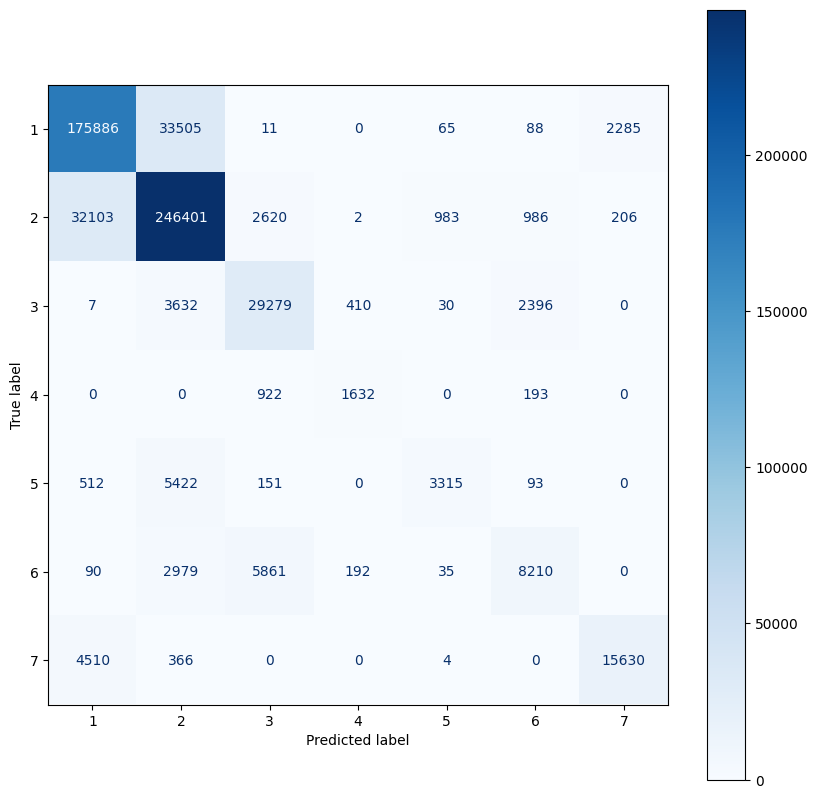

In [24]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.show()